In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "C:\\Deep learning\\final project\\Driver-Drowsiness-Detection\\dataset"
print(os.listdir(dataset_path)) # List files in the dataset


['Drowsy', 'Non Drowsy']


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip to generalize left/right faces
    transforms.RandomRotation(10),  # Slight rotation to account for natural head tilt
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variability in lighting
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  # Small shifts & rotations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Simulate motion blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=dataset_path, transform=transform)


In [5]:
train_val_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataset, val_dataset = random_split(train_val_dataset, [0.75, 0.25])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")


Training Samples: 25077
Validation Samples: 8358
Test Samples: 8358
Classes: ['Drowsy', 'Non Drowsy']


In [6]:
def plot_images_grid(dataloader, mean, std):
    for images, labels in dataloader:
        break
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    for ax, image, label in zip(axes.flatten(), images, labels):            
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        image = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(image)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Train set


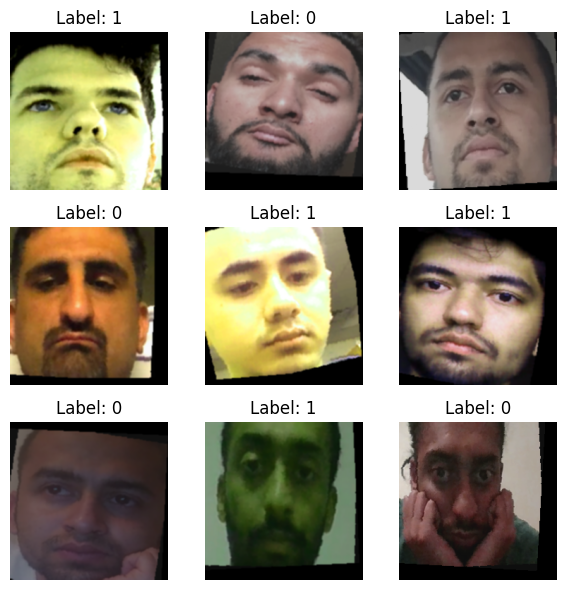

Valid set


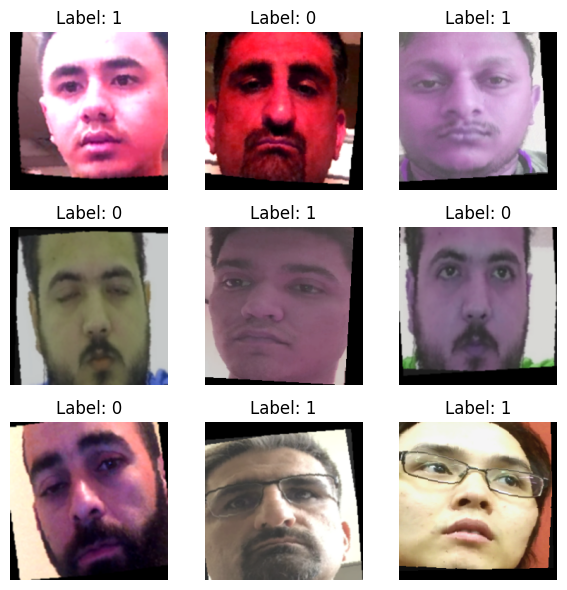

Test set


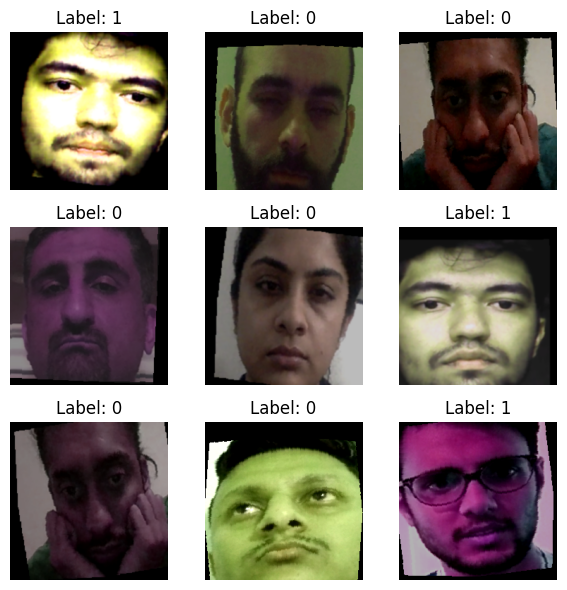

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
print("Train set"); plot_images_grid(train_loader, mean, std)
print("Valid set"); plot_images_grid(val_loader, mean, std)
print("Test set"); plot_images_grid(test_loader, mean, std)

In [8]:
# Load pre-trained MobileNetV3 Large
MobileNet = models.mobilenet_v3_large(pretrained=True)

# Modify the classifier to match your number of classes
num_classes = 2
MobileNet.classifier[3] = nn.Linear(MobileNet.classifier[3].in_features, num_classes)

# Move to device
MobileNet = MobileNet.to(device)


c:\Users\asus\miniconda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\miniconda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:

criterion = nn.CrossEntropyLoss()
# ✅ Use AdamW instead of Adam (better weight decay handling)
optimizer = optim.AdamW(MobileNet.parameters(), lr=0.0001, weight_decay=5e-4)
# ✅ Adjust Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Smooth lr decay

checkpoint_path = "checkpoint.pth"
best_model_path = "best_model.pth"
log_path = "training_log.txt"

In [10]:
checkpoint_path = "model_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    MobileNet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"✅ Checkpoint Loaded! Resuming from Epoch {start_epoch+1} with best loss {best_loss:.4f}")
else:
    start_epoch = 0
    best_loss = float("inf")


In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [12]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / total
    val_accuracy = correct / total

    return avg_val_loss, val_accuracy

In [13]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    print("Training complete.")
    return model, train_loss, val_loss, val_acc

In [14]:
def plot_training_metrics(train_losses, val_losses, val_accuracies, save_path="training_results.png"):
    """
    Plot training loss, validation loss, and validation accuracy over epochs.

    Parameters:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
        val_accuracies (list): Validation accuracy per epoch
        save_path (str): Path to save the resulting plot
    """
    plt.figure(figsize=(12, 6))

    # Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training plot saved to: {save_path}")

In [15]:
epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

patience = 3
counter = 0

In [16]:
trained_model, train_loss, val_loss, val_acc = train_model(MobileNet, train_loader, val_loader, device, epochs, lr=1e-4)


Epoch 1/10


Training: 100%|██████████| 784/784 [36:46<00:00,  2.81s/it]


Train Loss: 0.0663, Accuracy: 0.9740
Val   Loss: 0.0159, Accuracy: 0.9940
Best model saved!

Epoch 2/10


Training: 100%|██████████| 784/784 [49:44<00:00,  3.81s/it]


Train Loss: 0.0071, Accuracy: 0.9977
Val   Loss: 0.0004, Accuracy: 1.0000
Best model saved!

Epoch 3/10


Training: 100%|██████████| 784/784 [36:10<00:00,  2.77s/it]


Train Loss: 0.0042, Accuracy: 0.9987
Val   Loss: 0.0071, Accuracy: 0.9975

Epoch 4/10


Training: 100%|██████████| 784/784 [28:02<00:00,  2.15s/it]


Train Loss: 0.0038, Accuracy: 0.9988
Val   Loss: 0.0008, Accuracy: 0.9999

Epoch 5/10


Training: 100%|██████████| 784/784 [28:13<00:00,  2.16s/it]


Train Loss: 0.0037, Accuracy: 0.9991
Val   Loss: 0.0020, Accuracy: 0.9995

Epoch 6/10


Training: 100%|██████████| 784/784 [28:19<00:00,  2.17s/it]


Train Loss: 0.0022, Accuracy: 0.9992
Val   Loss: 0.0001, Accuracy: 1.0000

Epoch 7/10


Training: 100%|██████████| 784/784 [28:25<00:00,  2.18s/it]


Train Loss: 0.0022, Accuracy: 0.9993
Val   Loss: 0.0001, Accuracy: 1.0000

Epoch 8/10


Training: 100%|██████████| 784/784 [40:15<00:00,  3.08s/it]


Train Loss: 0.0013, Accuracy: 0.9997
Val   Loss: 0.0014, Accuracy: 0.9996

Epoch 9/10


Training: 100%|██████████| 784/784 [31:41<00:00,  2.43s/it]


Train Loss: 0.0035, Accuracy: 0.9992
Val   Loss: 0.0072, Accuracy: 0.9983

Epoch 10/10


Training: 100%|██████████| 784/784 [42:36<00:00,  3.26s/it]
                                                             

Train Loss: 0.0012, Accuracy: 0.9995
Val   Loss: 0.0001, Accuracy: 1.0000
Training complete.


In [17]:
#plot_training_metrics(train_loss, val_loss, val_acc, save_path="training_results.png")

In [18]:
import torch
from torchvision import models

# Define the number of output classes
NUM_CLASSES = len(dataset.classes)  # Make sure dataset is defined

# Load the MobileNetV3 model without pre-trained weights
model = models.mobilenet_v3_large(pretrained=False)

# Replace the final classification layer
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)

# Load the model weights from file
model.load_state_dict(torch.load("best_model.pth"))  # No weights_only param

# Move to device
model = model.to(device)
model.eval()

print(f"Model loaded successfully! Ready for {NUM_CLASSES} classes.")


c:\Users\asus\miniconda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully! Ready for 2 classes.


In [19]:
import torch
from torchvision import models

# Define the number of output classes
NUM_CLASSES = len(dataset.classes)  # Make sure dataset is defined

# Load the MobileNetV3 model without pre-trained weights
model = models.mobilenet_v3_large(pretrained=False)

# Replace the final classification layer
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)

# Load the model weights from file
model.load_state_dict(torch.load("best_model.pth"))  # No weights_only param

# Move to device
model = model.to(device)
model.eval()

print(f"✅ Model loaded successfully! Ready for {NUM_CLASSES} classes.")


✅ Model loaded successfully! Ready for 2 classes.


In [20]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = (correct / total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.98%


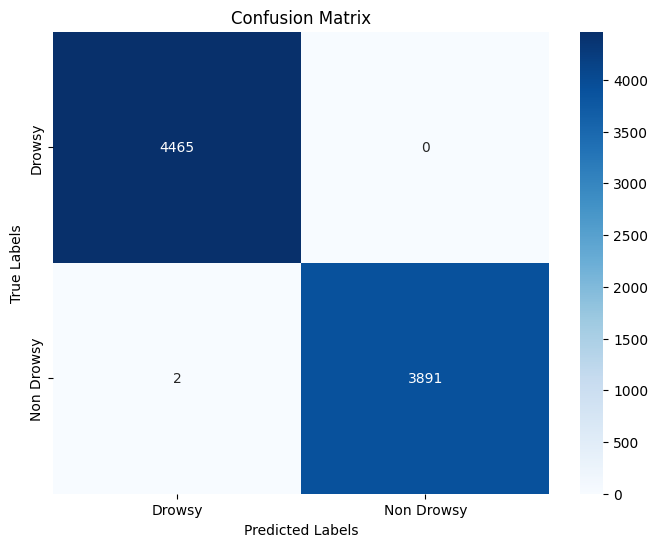

In [21]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
